<a href="https://colab.research.google.com/github/srikanthravipati27/House-price-prediction/blob/main/Copy_of_Housepriceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('/content/house_price_prediction_dataset.csv')

In [ ]:
X = df.drop('House Price', axis=1)
y = df['House Price'].values.reshape(-1, 1)

In [ ]:
num_cols = X.select_dtypes(include='float64').columns.tolist()
cat_cols = ['Neighborhood Quality']

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [ ]:
X_processed = preprocessor.fit_transform(X)

In [ ]:
y_mean, y_std = y.mean(), y.std()
y_normalized = (y - y_mean) / y_std

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_normalized, test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, activation='relu'):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.activation_type = activation.lower()

    def forward(self, x):
        out = self.linear(x)
        if self.activation_type == 'relu':
            return torch.relu(out)
        elif self.activation_type == 'tanh':
            return torch.tanh(out)
        else:
            return out


In [ ]:
def train_model(model, X, y, epochs=1000, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

In [ ]:
model_relu = SimpleNet(X_train.shape[1], activation='relu')
relu_losses = train_model(model_relu, X_train_tensor, y_train_tensor)
model_tanh = SimpleNet(X_train.shape[1], activation='tanh')
tanh_losses = train_model(model_tanh, X_train_tensor, y_train_tensor)


Epoch 0, Loss: 1.4004
Epoch 100, Loss: 0.7473
Epoch 200, Loss: 0.5712
Epoch 300, Loss: 0.5568
Epoch 400, Loss: 0.5527
Epoch 500, Loss: 0.5504
Epoch 600, Loss: 0.5488
Epoch 700, Loss: 0.5477
Epoch 800, Loss: 0.5470
Epoch 900, Loss: 0.5464
Epoch 0, Loss: 1.4073
Epoch 100, Loss: 0.3279
Epoch 200, Loss: 0.2581
Epoch 300, Loss: 0.2386
Epoch 400, Loss: 0.2286
Epoch 500, Loss: 0.2221
Epoch 600, Loss: 0.2174
Epoch 700, Loss: 0.2138
Epoch 800, Loss: 0.2108
Epoch 900, Loss: 0.2084


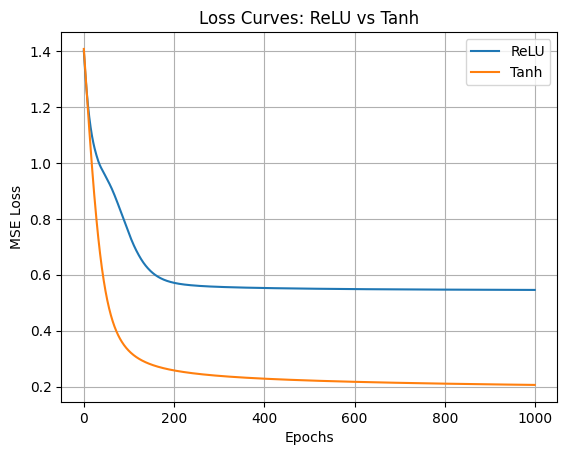

In [ ]:
plt.plot(relu_losses, label='ReLU')
plt.plot(tanh_losses, label='Tanh')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss Curves: ReLU vs Tanh")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model_relu.eval()
with torch.no_grad():
    predictions = model_relu(X_test_tensor)
preds = predictions.numpy() * y_std + y_mean
actuals = y_test_tensor.numpy() * y_std + y_mean
for i in range(5):
    print(f"Actual: ₹{actuals[i][0]:,.2f} | Predicted: ₹{preds[i][0]:,.2f}")


Actual: ₹574,086.14 | Predicted: ₹599,361.40
Actual: ₹588,372.03 | Predicted: ₹563,044.01
Actual: ₹497,364.50 | Predicted: ₹560,533.97
Actual: ₹527,053.95 | Predicted: ₹560,533.97
Actual: ₹641,177.14 | Predicted: ₹648,908.33
